In [1]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.providers.fake_provider import FakeVigoV2
from matplotlib import pyplot as plt
import os
import sys
import numpy as np

sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "pauli_lindblad_per"))

from tomography.experiment import SparsePauliTomographyExperiment as tomography
from primitives.pauli import QiskitPauli

plt.style.use("ggplot")

In [2]:
backend = FakeVigoV2()

In [3]:
def trotterLayer(h,J,dt,n):
    trotterLayer = QuantumCircuit(2*n)
    trotterLayer.rx(dt*4*h, range(2*n))
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.rz(-4*J*dt, [2*i+1 for i in range(n)])
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    trotterLayer.rz(-4*J*dt, [2*i+2 for i in range(n-1)])
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    return trotterLayer

h = 1
J = -.15
dt = .2
n = 2

def maketrotterCircuit(s):
    tL = trotterLayer(h, J, dt, n)
    trotterCircuit = QuantumCircuit(n*2)
    for i in range(s):
        trotterCircuit = trotterCircuit.compose(tL)
        trotterCircuit.barrier()

    transpiled = transpile(trotterCircuit, backend)
    return transpiled

circuits = [maketrotterCircuit(i) for i in range(1,15)]

In [4]:
def executor(circuits):
    return backend.run(circuits).result().get_counts()

In [5]:
experiment = tomography(circuits = circuits, inst_map = [0,1,2,3,4], backend = backend)

In [6]:
experiment.generate(samples = 16, single_samples = 100, depths = [2,4,8,16])

In [7]:
experiment.run(executor)

In [8]:
noisedataframe = experiment.analyze()

In [9]:
perexp = experiment.create_per_experiment(circuits)

In [10]:
expectations = ["ZIIII","IZIII","IIZII","IIIZI"]
perexp.generate(expectations = expectations, samples = 100, noise_strengths = [0,0.5,1,2])

## PER

In [11]:
perexp.run(executor)

In [12]:
circuit_results = perexp.analyze()

In [13]:
results = []
results_at_noise = []
for run in circuit_results:
    tot = 0
    tot_at_noise = array = [0 for _ in range(len(run.get_result(expectations[0]).get_strengths()))]
    for op in expectations:
        expec = run.get_result(op).expectation
        expec_at_noise = run.get_result(op).get_expectations()
        tot += expec
        for i in range(0,len(tot_at_noise)):
            tot_at_noise[i] += expec_at_noise[i]/4
    results.append(tot/4)
    results_at_noise.append(tot_at_noise)

In [14]:
results_at_noise[0]

[0.6207983179843123,
 0.7183079406722058,
 0.6739027561128056,
 0.6676601238732824]

In [15]:
for run in circuit_results:
    print(run.get_result(expectations[0]).get_strengths(), run.get_result(expectations[0]).get_expectations())

[0, 0.5, 1, 2] [0.6207295399726918, 0.723795076809072, 0.6803888124642843, 0.6795274810254035]
[0, 0.5, 1, 2] [-0.010385412236191603, -0.00026568190426846125, -0.016554370093613373, -0.036680114446001215]
[0, 0.5, 1, 2] [-0.8616638437622348, -0.699185329161161, -0.6757880420956277, -0.6587714941567611]
[0, 0.5, 1, 2] [-0.9079194191477806, -0.961150464522192, -0.8896083197768424, -0.8041684426566321]
[0, 0.5, 1, 2] [-0.4933890277275221, -0.6445570171495925, -0.5705375418811571, -0.5415673942173338]
[0, 0.5, 1, 2] [0.11735980964100168, 0.03013748308675618, 0.058402473172899955, 0.0454614935058113]
[0, 0.5, 1, 2] [0.8357841675983839, 0.7392985210879454, 0.6012723685904927, 0.5486471184832571]
[0, 0.5, 1, 2] [0.8990777225399826, 0.8339601035922024, 0.7467533494258641, 0.6434776090956567]
[0, 0.5, 1, 2] [0.7126542205918757, 0.510760174328158, 0.43957314700351025, 0.36881792051202583]
[0, 0.5, 1, 2] [-0.11256749282656545, -0.09017895588895945, -0.0823306807066888, -0.05224710459748279]
[0, 0

In [16]:
circuit_results[-1]._per_circ.overhead(0)

7.0495251756955915

In [17]:
noisyresult = []
for circ in circuits:
    qc = circ.copy()
    qc.measure_all()
    count= backend.run(qc).result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for bit in key[:4]])
        tot += num*count[key]
    noisyresult.append(tot/(1024*n*2))

Text(0, 0.5, 'Z Magnetization')

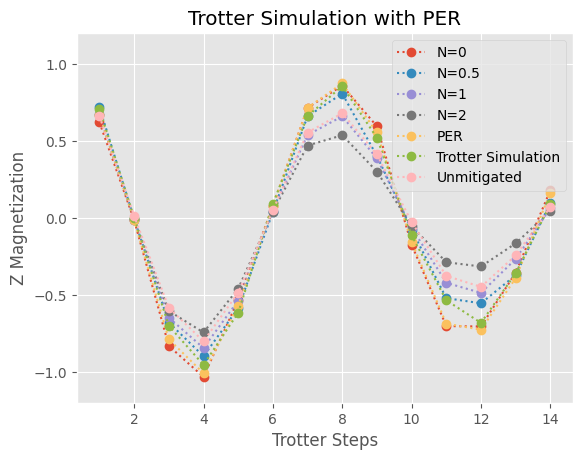

In [18]:
res = []
for circ in circuits:
    qc = circ.copy()
    qc.measure_all()
    count= Aer.get_backend('qasm_simulator').run(qc).result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for bit in key[:4]])
        tot += num*count[key]
    res.append(tot/(1024*n*2))

plt.plot(range(1,15), [res[0] for res in results_at_noise], 'o:')
plt.plot(range(1,15), [res[1] for res in results_at_noise], 'o:')
plt.plot(range(1,15), [res[2] for res in results_at_noise], 'o:')
plt.plot(range(1,15), [res[3] for res in results_at_noise], 'o:')
plt.plot(range(1,15), results, 'o:')
plt.plot(range(1,15), res, 'o:')
plt.plot(range(1,15), noisyresult, 'o:')
plt.ylim([-1.2,1.2])
plt.legend(["N=0", "N=0.5", "N=1", "N=2", "PER", "Trotter Simulation", "Unmitigated"])
plt.title("Trotter Simulation with PER")
plt.xlabel("Trotter Steps")
plt.ylabel("Z Magnetization")

Text(0.5, 1.0, 'Expectation vs Noise Strength IIIZ')

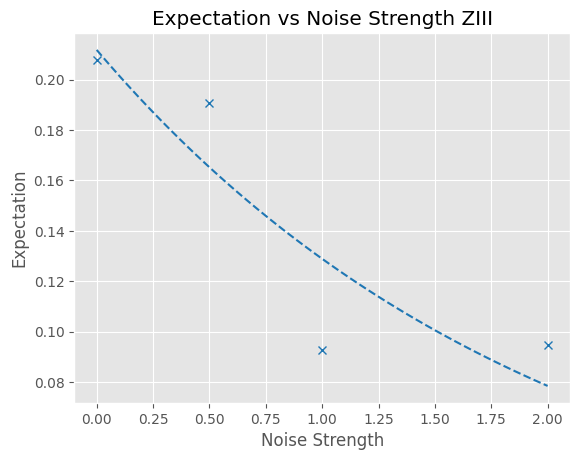

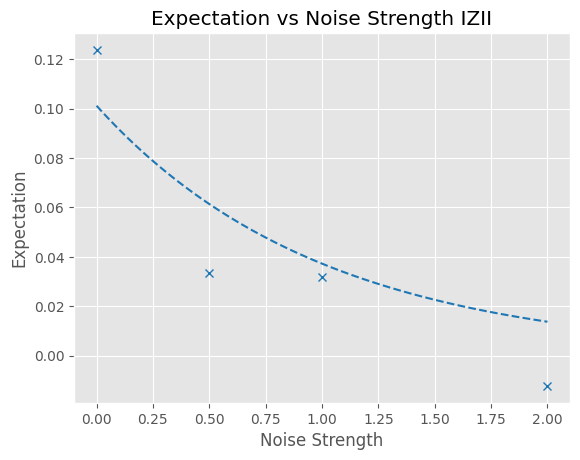

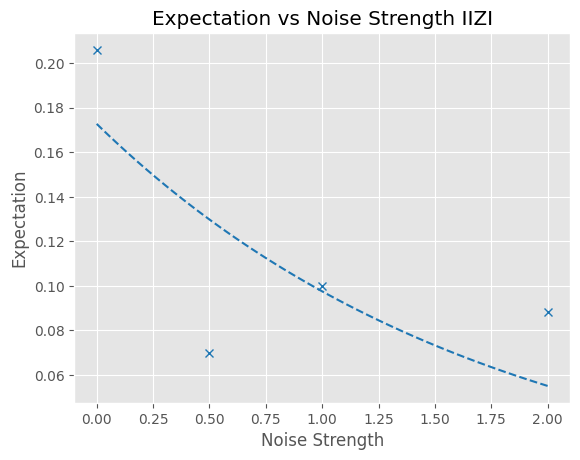

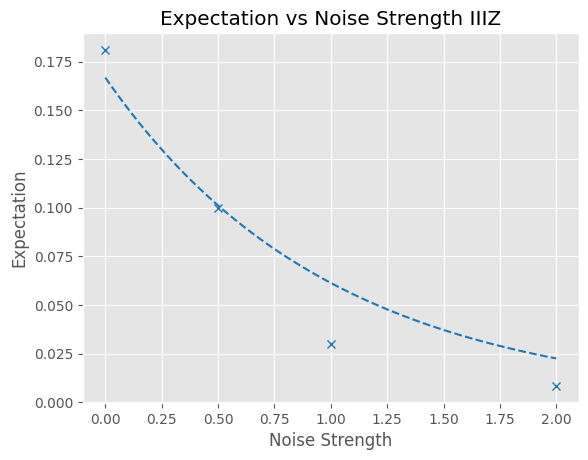

In [19]:
ax = circuit_results[-1].get_result("ZIIII").plot()
plt.title('Expectation vs Noise Strength ZIII')
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
circuit_results[-1].get_result("IZIII").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IZII')
circuit_results[-1].get_result("IIZII").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IIZI')
circuit_results[-1].get_result("IIIZI").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IIIZ')

## Analysis

In [20]:
layer1 = experiment.analysis.get_layer_data(0)

<Axes: >

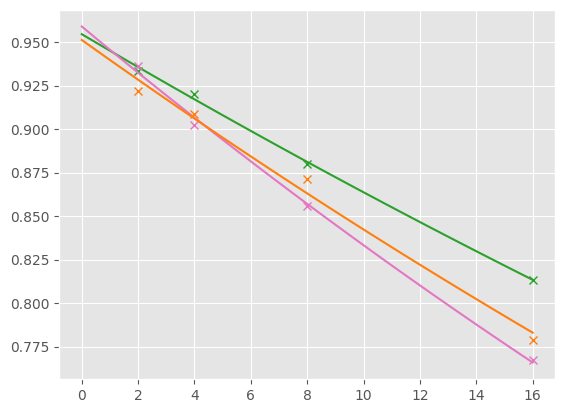

In [21]:
layer1.graph((1,))

<Axes: >

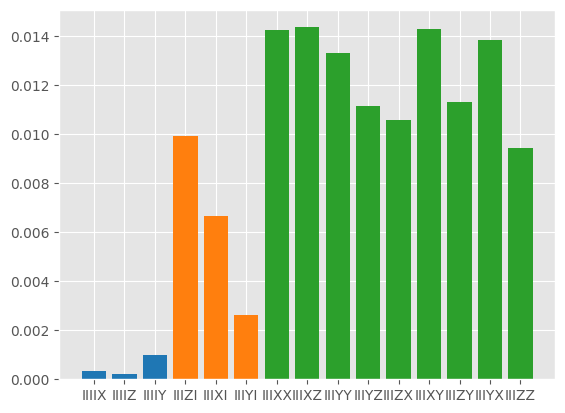

In [22]:
layer1.plot_infidelitites((0,),(1,),(0,1))

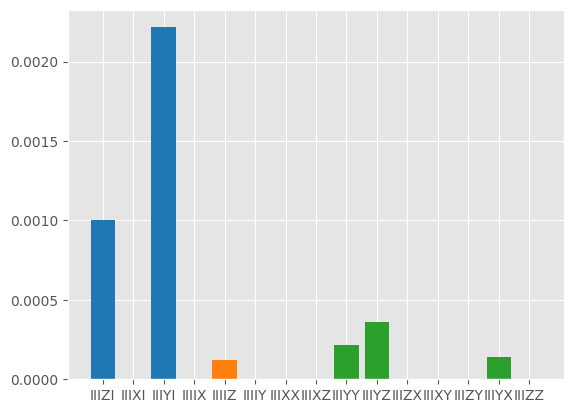

In [23]:
layer1.plot_coeffs((1,),(0,),(0,1))

In [24]:
import pickle
with open("graph.pickle", "wb") as f:
    pickle.dump(results, f)